In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

# 데이터 불러오기
df = pd.read_csv("https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/BP_data.csv")
df

,Patient_Number,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders
0,1,1,11.28,0.90,34,23,1,1.0,0,45961,48071,NaN,2,1,1
1,2,0,9.75,0.23,54,33,1,NaN,0,26106,25333,205.0,3,0,0
2,3,1,10.79,0.91,70,49,0,NaN,0,9995,29465,67.0,2,1,0
3,4,0,11.00,0.43,71,50,0,NaN,0,10635,7439,242.0,1,1,0
4,5,1,14.17,0.83,52,19,0,NaN,0,15619,49644,397.0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,1,10.14,0.02,69,26,1,NaN,1,26118,47568,144.0,3,1,0
1996,1997,1,11.77,1.00,24,45,1,1.0,1,2572,8063,NaN,3,1,1
1997,1998,1,16.91,0.22,18,42,0,NaN,0,14933,24753,NaN,2,1,1
1998,1999,0,11.15,0.72,46,45,1,NaN,1,18157,15275,253.0,3,0,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Patient_Number                 2000 non-null   int64  
 1   Blood_Pressure_Abnormality     2000 non-null   int64  
 2   Level_of_Hemoglobin            2000 non-null   float64
 3   Genetic_Pedigree_Coefficient   1908 non-null   float64
 4   Age                            2000 non-null   int64  
 5   BMI                            2000 non-null   int64  
 6   Sex                            2000 non-null   int64  
 7   Pregnancy                      442 non-null    float64
 8   Smoking                        2000 non-null   int64  
 9   Physical_activity              2000 non-null   int64  
 10  salt_content_in_the_diet       2000 non-null   int64  
 11  alcohol_consumption_per_day    1758 non-null   float64
 12  Level_of_Stress                2000 non-null   i

In [9]:
# 레이블 갯수 확인 (숫자)
df['Blood_Pressure_Abnormality'].value_counts()

0    1013
1     987
Name: Blood_Pressure_Abnormality, dtype: int64

In [10]:
df.columns

Index(['Patient_Number', 'Blood_Pressure_Abnormality', 'Level_of_Hemoglobin',
       'Genetic_Pedigree_Coefficient', 'Age', 'BMI', 'Sex', 'Pregnancy',
       'Smoking', 'Physical_activity', 'salt_content_in_the_diet',
       'alcohol_consumption_per_day', 'Level_of_Stress',
       'Chronic_kidney_disease', 'Adrenal_and_thyroid_disorders'],
      dtype='object')

## EDA 실행

In [11]:
# 결측치 확인
# 특정 결측치를 2로 바꾸는 함수 -> fillna(2)
df.isnull().sum()
df['Genetic_Pedigree_Coefficient'] = df['Genetic_Pedigree_Coefficient'].fillna(2)
df['Pregnancy'] = df['Pregnancy'].fillna(0) # 임신 여부는 0과 1
df['alcohol_consumption_per_day'] = df['alcohol_consumption_per_day'].fillna(2)

In [12]:
columns = ['Patient_Number', 'Blood_Pressure_Abnormality', 'Level_of_Hemoglobin',
       'Genetic_Pedigree_Coefficient', 'Age', 'BMI', 'Sex', 'Pregnancy',
       'Smoking', 'Physical_activity', 'salt_content_in_the_diet',
       'alcohol_consumption_per_day', 'Level_of_Stress',
       'Chronic_kidney_disease', 'Adrenal_and_thyroid_disorders']

### countplot
- 카테고리형 데이터의 빈도(횟수)를 시각화하는 막대그래프

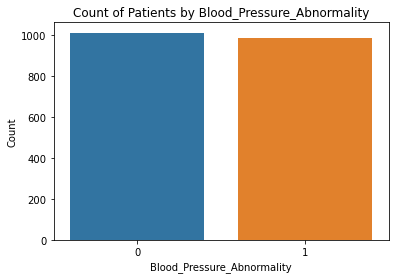

In [13]:
# countplot 활용
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Blood_Pressure_Abnormality', data=df)
plt.title('Count of Patients by Blood_Pressure_Abnormality')
plt.xlabel('Blood_Pressure_Abnormality')
plt.ylabel('Count')
plt.show()

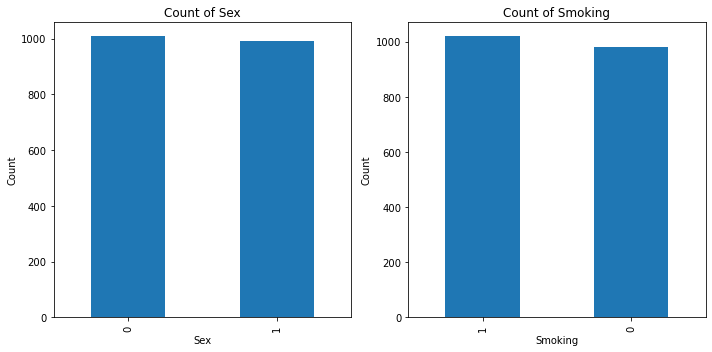

In [14]:
# countplot 활용
import matplotlib.pyplot as plt

cols = ['Sex', 'Smoking']
counts = {col: df[col].value_counts() for col in cols}

fig, axes = plt.subplots(1, len(cols), figsize=(5 * len(cols), 5))

for i, col in enumerate(cols):
    counts[col].plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Count of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()


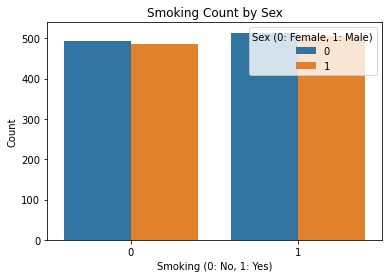

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Smoking', hue='Sex', data=df)
plt.title('Smoking Count by Sex')
plt.xlabel('Smoking (0: No, 1: Yes)')
plt.ylabel('Count')
plt.legend(title='Sex (0: Female, 1: Male)')
plt.show()

### boxplot
- 데이터의 분포(사분위수, 중간값, 이상치 등)를 시각화하는 그래프
- 숫자형 데이터의 중앙값, 범위, 이상치를 한눈에 파악할 수 있음

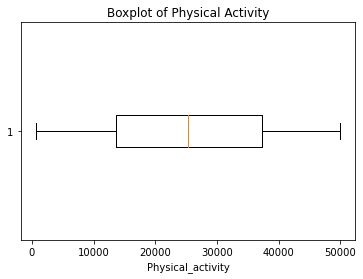

In [16]:
# boxplot 활용
import matplotlib.pyplot as plt

plt.boxplot(df['Physical_activity'].dropna(), vert=False)
plt.title('Boxplot of Physical Activity')
plt.xlabel('Physical_activity')
plt.show()


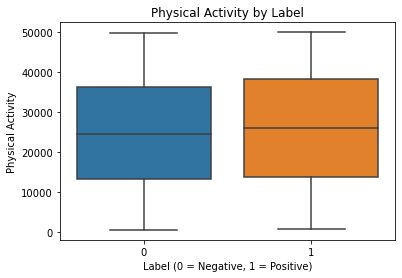

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# label의 값에 따라서 특정 값을 보여주는 boxplot 

sns.boxplot(x='Blood_Pressure_Abnormality', y='Physical_activity', data=df)
plt.title('Physical Activity by Label')
plt.xlabel('Label (0 = Negative, 1 = Positive)')
plt.ylabel('Physical Activity')
plt.show()

### violinplot
- 데이터의 분포(확률 밀도)와 사분위수, 중앙값을 동시에 보여주는 그래프

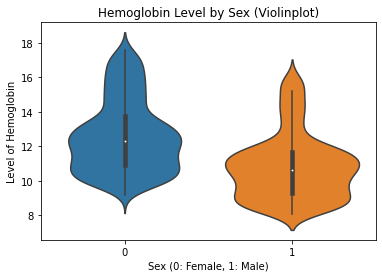

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(x='Sex', y='Level_of_Hemoglobin', data=df)
plt.title('Hemoglobin Level by Sex (Violinplot)')
plt.xlabel('Sex (0: Female, 1: Male)')
plt.ylabel('Level of Hemoglobin')
plt.show()


### heatmap
- 행렬 형태의 데이터를 색상으로 시각화하는 그래프
- 숫자값을 색으로 표현해서 패턴, 상관관계, 크기 차이를 한눈에 볼 수 있다

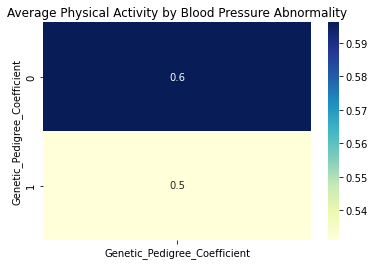

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 피벗 테이블 생성 (행 기준: 혈압 이상 여부, 열 기준: dummy)
pivot_table = df.pivot_table(
    index='Blood_Pressure_Abnormality',
    values='Genetic_Pedigree_Coefficient',
    aggfunc='mean'  # 평균값 사용 (sum, count 등도 가능)
)

# 히트맵 시각화
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt=".1f")
plt.title('Average Physical Activity by Blood Pressure Abnormality')
plt.ylabel('Genetic_Pedigree_Coefficient')
plt.xlabel('')  # 열이 하나뿐이라 안 보이게 처리
plt.show()


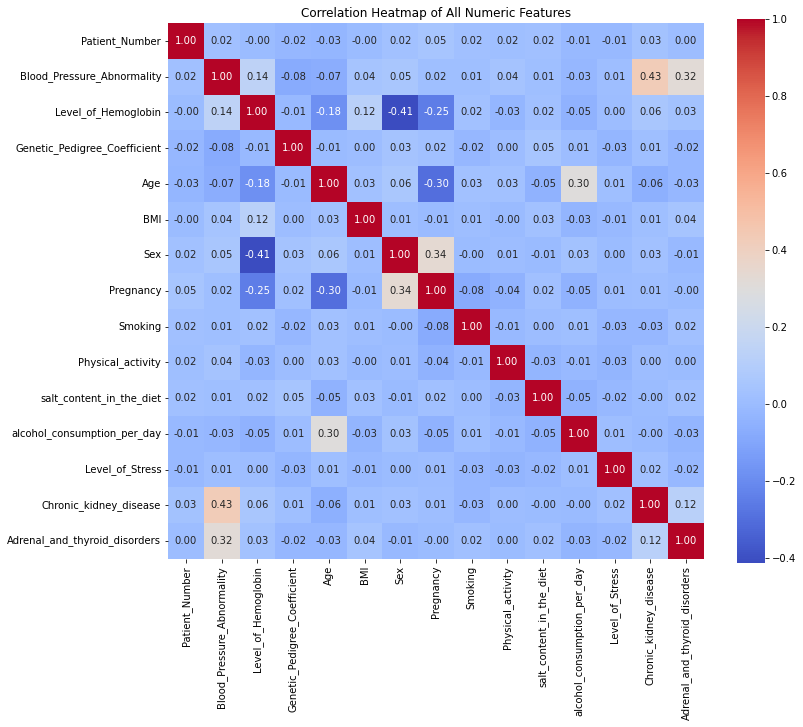

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# 수치형 변수만 추출
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# 상관계수 행렬 계산
corr = numeric_df.corr()

# Heatmap 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of All Numeric Features')
plt.show()


### histplot
- 히스토그램을 그리는 함수로, 숫자형 데이터의 분포를 구간별 막대로 시각화하는 그래프

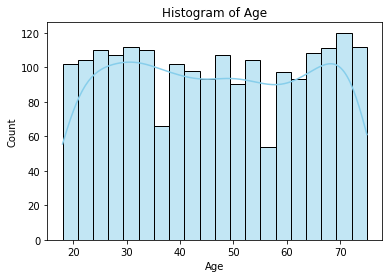

In [21]:
# histoplot 활용
import seaborn as sns

sns.histplot(df['Age'].dropna(), bins=20, kde=True, color='skyblue')
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


### kdeplot
- 히스토그램처럼 데이터의 분포를 시각화하지만, 막대 대신 부드러운 곡선 (밀도 곡선) 으로 표현

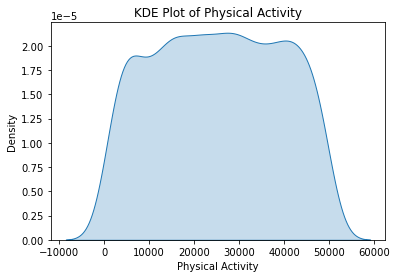

In [22]:
# kdeplot
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(df['Physical_activity'].dropna(), shade=True)
plt.title('KDE Plot of Physical Activity')
plt.xlabel('Physical Activity')
plt.ylabel('Density')
plt.show()


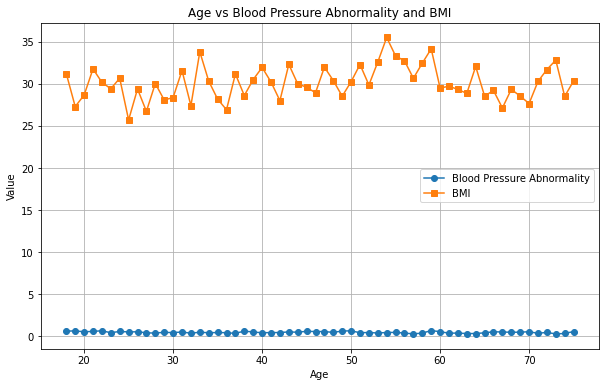

In [23]:
# 책 예제
import matplotlib.pyplot as plt

df_grouped = df.groupby('Age')[['Blood_Pressure_Abnormality', 'BMI']].mean()

plt.figure(figsize=(10, 6))
plt.plot(df_grouped.index, df_grouped['Blood_Pressure_Abnormality'], label='Blood Pressure Abnormality', marker='o')
plt.plot(df_grouped.index, df_grouped['BMI'], label='BMI', marker='s')

plt.title('Age vs Blood Pressure Abnormality and BMI')
plt.xlabel('Age')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


### scatterplot
- 두 수치형 변수 간의 관계를 점으로 시각화하는 그래프

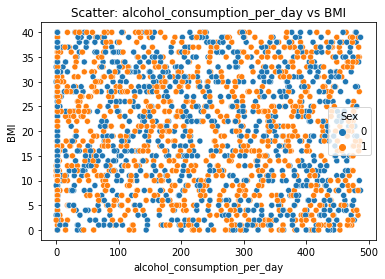

In [44]:
# scatter(산점도, 상관관계)
import seaborn as sns

sns.scatterplot(x='alcohol_consumption_per_day', y='BMI', hue='Sex', data=df)
plt.title('Scatter: alcohol_consumption_per_day vs BMI')
plt.show()


### scatter

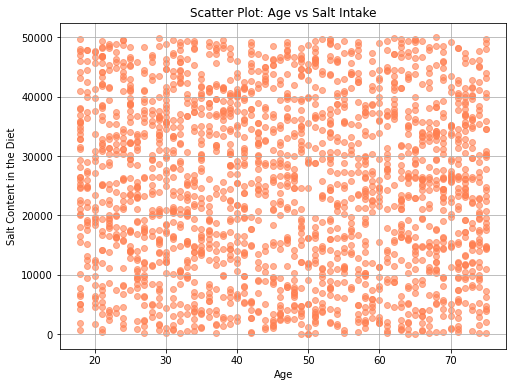

In [25]:
# 나이에 따른 염분 섭취량
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df['Age'], df['salt_content_in_the_diet'], alpha=0.6, color='coral')

plt.title('Scatter Plot: Age vs Salt Intake')
plt.xlabel('Age')
plt.ylabel('Salt Content in the Diet')
plt.grid(True)
plt.show()


## 분류 모델 생성 실습

In [26]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for column in columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

In [27]:
df

,Patient_Number,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders
0,0,1,296,90,16,13,1,1,0,1798,1880,2,1,1,1
1,1,0,146,23,36,23,1,0,0,1006,987,199,2,0,0
2,2,1,248,91,52,39,0,0,0,361,1152,63,1,1,0
3,3,0,269,43,53,40,0,0,0,383,286,235,0,1,0
4,4,1,553,83,34,9,0,0,0,570,1937,389,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,1,184,2,51,16,1,0,1,1007,1862,139,2,1,0
1996,1996,1,345,100,6,35,1,1,1,69,312,2,2,1,1
1997,1997,1,727,22,0,32,0,0,0,550,961,2,1,1,1
1998,1998,0,283,72,28,35,1,0,1,684,586,246,2,0,1


In [28]:
# 데이터와 타겟 분리
X = df.drop('Blood_Pressure_Abnormality', axis=1).values
y = df['Blood_Pressure_Abnormality'].values

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 14), (400, 14), (1600,), (400,))

In [30]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [31]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1600, 14]),
 torch.Size([400, 14]),
 torch.Size([1600]),
 torch.Size([400]))

In [33]:
class DiabatesModel(nn.Module):
    def __init__(self):
        super(DiabatesModel, self).__init__()
        self.model = nn.Sequential(
           nn.Linear(14, 128),
           nn.ReLU(),
           nn.Linear(128, 64),
           nn.ReLU(),
           nn.Linear(64, 32),
           nn.ReLU(),
           nn.Linear(32, 16),
           nn.ReLU(),
           nn.Linear(16, 2)
        )

    def forward(self, x):
        return self.model(x)

# Initialize the model, loss function, and optimizer
model = DiabatesModel()

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [35]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 0.6648, Accuracy: 73.25%
Epoch 2/20, Loss: 0.5353, Accuracy: 72.50%
Epoch 3/20, Loss: 0.4950, Accuracy: 75.00%
Epoch 4/20, Loss: 0.4571, Accuracy: 79.25%
Epoch 5/20, Loss: 0.4071, Accuracy: 83.00%
Epoch 6/20, Loss: 0.3589, Accuracy: 83.00%
Epoch 7/20, Loss: 0.3312, Accuracy: 84.75%
Epoch 8/20, Loss: 0.3004, Accuracy: 83.50%
Epoch 9/20, Loss: 0.2951, Accuracy: 85.00%
Epoch 10/20, Loss: 0.2792, Accuracy: 84.00%
Epoch 11/20, Loss: 0.2606, Accuracy: 82.50%
Epoch 12/20, Loss: 0.2528, Accuracy: 84.50%
Epoch 13/20, Loss: 0.2366, Accuracy: 83.75%
Epoch 14/20, Loss: 0.2249, Accuracy: 85.75%
Epoch 15/20, Loss: 0.2129, Accuracy: 85.00%
Epoch 16/20, Loss: 0.2051, Accuracy: 81.75%
Epoch 17/20, Loss: 0.2015, Accuracy: 83.75%
Epoch 18/20, Loss: 0.1794, Accuracy: 85.00%
Epoch 19/20, Loss: 0.1634, Accuracy: 84.00%
Epoch 20/20, Loss: 0.1519, Accuracy: 85.00%
Training complete.


In [36]:
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[185  23]
 [ 37 155]]
F1 Score: 0.85
Precision: 0.85
Recall: 0.85
Specificity: 0.85


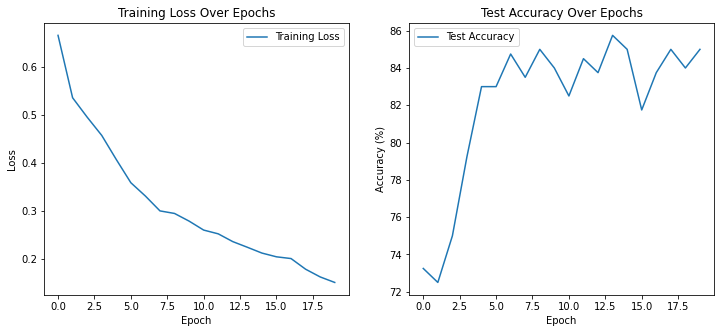

In [37]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()